In [1]:
import pandas as pd
import os

# Define the path to your data file
data_path = os.path.join('..', 'data', 'WA_Fn-UseC_-Telco-Customer-Churn.csv') 

# Load the dataset
df = pd.read_csv(data_path)

# Display the first 5 rows and the column information
print("First 5 Rows of Data:")
print(df.head())
print("\nData Information:")
df.info()

First 5 Rows of Data:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovie

In [3]:
# 1. Identify and handle missing values in 'TotalCharges'
# The info() output showed 'TotalCharges' is type 'object', which usually means it contains non-numeric values (like a space ' ')
# First, convert to numeric, coercing errors (the spaces) to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Now check for any missing (NaN) values across the entire DataFrame
print("Missing values per column after correction:")
print(df.isnull().sum())

# Fill the few resulting missing values in TotalCharges with the mean (or drop them, but filling is often better for a few)
# The count will be very low (usually 11 in this dataset)
df.dropna(inplace=True) 
# Or: df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)
# For simplicity, let's drop them as the number is small and we want clean data for the model

print("\nDataFrame size after dropping rows with missing values:")
print(f"Rows: {len(df)}")

Missing values per column after correction:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

DataFrame size after dropping rows with missing values:
Rows: 7032


In [5]:
# 2. Analyze the 'Churn' (Target) variable
churn_counts = df['Churn'].value_counts()
churn_rate = churn_counts['Yes'] / len(df) * 100

print("\nChurn Distribution:")
print(churn_counts)
print(f"\nOverall Churn Rate (Business KPI): {churn_rate:.2f}%")


Churn Distribution:
Churn
No     5163
Yes    1869
Name: count, dtype: int64

Overall Churn Rate (Business KPI): 26.58%


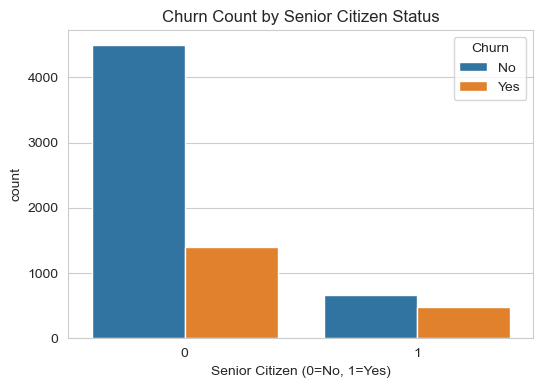


Churn Rate by Senior Citizen Status:
SeniorCitizen
0    23.65
1    41.68
Name: Yes, dtype: float64


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the visualization style
sns.set_style("whitegrid")

# Analyze Churn vs. Senior Citizen Status (a key demographic)
plt.figure(figsize=(6, 4))
sns.countplot(x='SeniorCitizen', hue='Churn', data=df)
plt.title('Churn Count by Senior Citizen Status')
plt.xlabel('Senior Citizen (0=No, 1=Yes)')
plt.show()

# Calculate Churn Rate by Senior Citizen Status
senior_churn_rate = df.groupby('SeniorCitizen')['Churn'].value_counts(normalize=True).mul(100).unstack()['Yes']
print("\nChurn Rate by Senior Citizen Status:")
print(senior_churn_rate.round(2))

In [10]:
# Drop Customer ID
df.drop('customerID', axis=1, inplace=True)

In [12]:
# Convert 'Churn' from text to 1s and 0s
df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})

C:\Users\HP\AppData\Local\Temp\ipykernel_6512\1122920016.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})


In [14]:
# Separate features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify all categorical features (which are currently 'object' type)
categorical_features = X.select_dtypes(include='object').columns

# Apply One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print("Shape of X (features) after encoding:")
print(X_encoded.shape)
print("\nFirst 5 rows of the encoded features:")
print(X_encoded.head())

Shape of X (features) after encoding:
(7032, 30)

First 5 rows of the encoded features:
   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  gender_Male  \
0              0       1           29.85         29.85        False   
1              0      34           56.95       1889.50         True   
2              0       2           53.85        108.15         True   
3              0      45           42.30       1840.75         True   
4              0       2           70.70        151.65        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0         True           False             False   
1        False           False              True   
2        False           False              True   
3        False           False             False   
4        False           False              True   

   MultipleLines_No phone service  MultipleLines_Yes  ...  \
0                            True              False  ...   
1                           False              Fal

In [16]:
from sklearn.model_selection import train_test_split

# Split the data (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)} rows")
print(f"Testing set size: {len(X_test)} rows")

Training set size: 5625 rows
Testing set size: 1407 rows


In [18]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test)

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
from sklearn.metrics import confusion_matrix, classification_report

# Print the full classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn (0)', 'Churn (1)']))

# Display the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Functional Interpretation:
# True Positives (TP): cm[1, 1] - Customers who were predicted to churn AND actually churned (SUCCESSFUL CATCH)
# False Positives (FP): cm[0, 1] - Customers who were predicted to churn BUT DID NOT (wasted retention effort)
# False Negatives (FN): cm[1, 0] - Customers who were NOT predicted to churn BUT ACTUALLY CHURNED (MISSED OPPORTUNITY)
print(f"\nModel successfully identified {cm[1, 1]} true churners (TP).")
print(f"Model missed {cm[1, 0]} churners (FN) - this is the business risk.")

Classification Report:
              precision    recall  f1-score   support

No Churn (0)       0.85      0.89      0.87      1033
   Churn (1)       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407


Confusion Matrix:
[[916 117]
 [159 215]]

Model successfully identified 215 true churners (TP).
Model missed 159 churners (FN) - this is the business risk.


In [22]:
import numpy as np

# Get feature coefficients (importance) from the Logistic Regression model
coefficients = log_reg_model.coef_[0]
feature_names = X_encoded.columns

# Create a DataFrame for easy viewing and sorting
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print("\nTop 10 Positive Predictors of CHURN (Functional Insights):")
# Positive coefficient means it increases the probability of churn (1)
print(feature_importance.head(10).round(3))

print("\nTop 10 Negative Predictors of CHURN (Retention Factors):")
# Negative coefficient means it decreases the probability of churn (1) / increases retention
print(feature_importance.tail(10).round(3))


Top 10 Positive Predictors of CHURN (Functional Insights):
                                  Feature  Coefficient
10            InternetService_Fiber optic        0.742
28         PaymentMethod_Electronic check        0.393
26                   PaperlessBilling_Yes        0.295
9                       MultipleLines_Yes        0.293
8          MultipleLines_No phone service        0.252
21                        StreamingTV_Yes        0.228
23                    StreamingMovies_Yes        0.200
0                           SeniorCitizen        0.197
29             PaymentMethod_Mailed check        0.079
27  PaymentMethod_Credit card (automatic)        0.046

Top 10 Negative Predictors of CHURN (Retention Factors):
                                Feature  Coefficient
18      TechSupport_No internet service       -0.117
20      StreamingTV_No internet service       -0.117
22  StreamingMovies_No internet service       -0.117
15                     OnlineBackup_Yes       -0.199
6           

In [24]:
import joblib
import os

# Define the path to save the model
model_path = os.path.join('..', 'models', 'churn_predictor_log_reg.pkl')

# Save the model object
joblib.dump(log_reg_model, model_path)
print(f"\nModel successfully saved to: {model_path}")


Model successfully saved to: ..\models\churn_predictor_log_reg.pkl
